In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean
import warnings
warnings.filterwarnings("ignore")

In [18]:
# ##Unparameterized run
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/default_noparameterization
# fs = xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)

# #Contains default setup based on Jansen et al 2019. MEKE_VISCOSITY_COEFF_KU = -0.15; MEKE_KHCOEFF = 0.15
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_default_Laplacian
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# # MEKE_VISCOSITY_COEFF_KU = -0.15; MEKE_KHCOEFF = 0.3
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test1
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)


# ## MEKE_VISCOSITY_COEFF_KU = -0.15; MEKE_KHCOEFF = 0.5
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test2
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)


# # MEKE_VISCOSITY_COEFF_KU = -0.3; MEKE_KHCOEFF = 0.15
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test3
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)


# # MEKE_VISCOSITY_COEFF_KU = -0.5; MEKE_KHCOEFF = 0.15
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test4
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)


# # MEKE_VISCOSITY_COEFF_KU = -0.3; MEKE_KHCOEFF = 0.3
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test5
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)


# ## MEKE_VISCOSITY_COEFF_KU = -0.5; MEKE_KHCOEFF = 0.5
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test6
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.0; MEKE_KHCOEFF = 0.5
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test7
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.0; MEKE_KHCOEFF = 0.6
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test8
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.0; MEKE_KHCOEFF = 0.8
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test9
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.3; MEKE_KHCOEFF = 0.5
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test10
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.5; MEKE_KHCOEFF = 0.3
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test11
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.6; MEKE_KHCOEFF = 0.6
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test12
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.8; MEKE_KHCOEFF = 0.8
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test13
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.2; MEKE_KHCOEFF = 0.2
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test14
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# # MEKE_VISCOSITY_COEFF_KU = -0.15; MEKE_KHCOEFF = 0
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test15
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# # MEKE_VISCOSITY_COEFF_KU = -0.3; MEKE_KHCOEFF = 0
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test16
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.6; MEKE_KHCOEFF = 0.15
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test21
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0; MEKE_KHCOEFF = 0.15
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test24
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0; MEKE_KHCOEFF = 0.3
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test25
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.1; MEKE_KHCOEFF = 0
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test26
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.2; MEKE_KHCOEFF = 0
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test27
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)


##GME RUNS:
## MEKE_VISCOSITY_COEFF_KU = -0; MEKE_KHCOEFF = 0.3 with advection and dissipation of MEKE
# %cd /glade/p/univ/unyu0004/eyankovsky/GME_testing/GME_test1
# fs=xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc', decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0; MEKE_KHCOEFF = 0.3 with NO advection and dissipation of MEKE
# %cd /glade/p/univ/unyu0004/eyankovsky/GME_testing/GME_test2
# fs=xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc', decode_times=False)
# MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

## MEKE_VISCOSITY_COEFF_KU = -0; MEKE_KHCOEFF = 0.3 with advection and dissipation of MEKE, additional filtering (5 passes vs. 1 in test1&2)
%cd /glade/p/univ/unyu0004/eyankovsky/GME_testing/GME_test3
fs=xr.open_dataset('static.nc', decode_times=False)
av = xr.open_dataset('averages_00031502.nc', decode_times=False)
MEKEav=xr.open_dataset('MEKEaverages_00031502.nc',decode_times=False)

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


/glade/p/univ/unyu0004/eyankovsky/GME_testing/GME_test3
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [19]:
#Read in various grid variables from the static file:

depth = np.array(fs['depth_ocean'])
area_t=np.array(fs['area_t'])

xh = fs.xh.values
yh = fs.yh.values


KEterm1 = av['dKE_dt'][:,:,:,:].mean('time')
#assuming all of these are on the RHS of the KE equation
KEterm2 = av['KE_CorAdv'][:,:,:,:].mean('time')
#KEterm2_alternate = av['KE_adv'][:,:,:,:].mean('time')
KEterm3 = av['PE_to_KE'][:,:,:,:].mean('time')
KEterm4 = av['KE_BT'][:,:,:,:].mean('time')
KEterm5 = av['KE_visc'][:,:,:,:].mean('time')
KEterm6 = av['KE_horvisc'][:,:,:,:].mean('time')
#KE_stress = av['KE_stress'][:,:,:,:]#.mean('time') # Part of KEterm5, corresponds to surface wind stress contribution

#Summing vertically:
KEterm1 = (KEterm1).sum(axis=0);
KEterm2 = (KEterm2).sum(axis=0);
KEterm3 = (KEterm3).sum(axis=0);
KEterm4 = (KEterm4).sum(axis=0);
KEterm5 = (KEterm5).sum(axis=0);
KEterm6 = (KEterm6).sum(axis=0);
#KE_stress = KE_stress.sum(axis=0)

# #Or picking one layer:
# k=3
# KEterm1 = (KEterm1)[0,k,:,:]#.sum(axis=0);
# KEterm2 = (KEterm2)[0,k,:,:]#.sum(axis=0);
# KEterm3 = (KEterm3)[0,k,:,:]#.sum(axis=0);
# KEterm4 = (KEterm4)[0,k,:,:]#.sum(axis=0);
# KEterm5 = (KEterm5)[0,k,:,:]#.sum(axis=0);
# KEterm6 = (KEterm6)[0,k,:,:]#.sum(axis=0);

E = KEterm1-KEterm2-KEterm3-KEterm4-KEterm5-KEterm6 #residual term between dKE/dt and RHS of equation
#E_alternate = KEterm1-KEterm2_alternate-KEterm3-KEterm4-KEterm5-KEterm6

In [20]:
print(MEKEav)
MEKE = MEKEav['MEKE'][:,:,:].mean('time')
MEKE_KH = MEKEav['MEKE_KH'][:,:,:].mean('time')
MEKE_KU = MEKEav['MEKE_KU'][:,:,:].mean('time')
#MEKE_AU = MEKEav['MEKE_AU'][:,:,:].mean('time') #all 0s
MEKE_Ue = MEKEav['MEKE_Ue'][:,:,:].mean('time')
MEKE_Ub = MEKEav['MEKE_Ub'][:,:,:].mean('time')
MEKE_Ut = MEKEav['MEKE_Ut'][:,:,:].mean('time')
MEKE_src = MEKEav['MEKE_src'][:,:,:].mean('time')
MEKE_decay = MEKEav['MEKE_decay'][:,:,:].mean('time')
MEKE_GM_src = MEKEav['MEKE_GM_src'][:,:,:].mean('time')
MEKE_mom_src = MEKEav['MEKE_mom_src'][:,:,:].mean('time')
#MEKE_GME_snk = MEKEav['MEKE_GME_snk'][:,:,:].mean('time') #all 0s
MEKE_Le = MEKEav['MEKE_Le'][:,:,:].mean('time')
MEKE_Lrhines = MEKEav['MEKE_Lrhines'][:,:,:].mean('time')
#MEKE_Leady = MEKEav['MEKE_Leady'][:,:,:].mean('time')     #all 0s
#MEKE_gamma_b = MEKEav['MEKE_gamma_b'][:,:,:].mean('time') #all 1s
#MEKE_gamma_t = MEKEav['MEKE_gamma_t'][:,:,:].mean('time') #all 1s
KHMEKE_u = MEKEav['KHMEKE_u'][:,:,:].mean('time')
KHMEKE_v = MEKEav['KHMEKE_v'][:,:,:].mean('time')

<xarray.Dataset>
Dimensions:        (nv: 2, time: 100, xh: 120, xq: 121, yh: 280, yq: 281, zl: 15)
Coordinates:
  * xh             (xh) float64 0.25 0.75 1.25 1.75 ... 58.25 58.75 59.25 59.75
  * yh             (yh) float64 -69.75 -69.25 -68.75 ... 68.75 69.25 69.75
  * zl             (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time           (time) float64 3.15e+04 3.151e+04 ... 3.199e+04 3.2e+04
  * nv             (nv) float64 1.0 2.0
  * xq             (xq) float64 0.0 0.5 1.0 1.5 2.0 ... 58.0 58.5 59.0 59.5 60.0
  * yq             (yq) float64 -70.0 -69.5 -69.0 -68.5 ... 68.5 69.0 69.5 70.0
Data variables:
    KHTH_t         (time, zl, yh, xh) float32 ...
    GMwork         (time, yh, xh) float32 ...
    MEKE           (time, yh, xh) float32 ...
    MEKE_KH        (time, yh, xh) float32 ...
    MEKE_KU        (time, yh, xh) float32 ...
    MEKE_AU        (time, yh, xh) float32 ...
    MEKE_Ue        (time, yh, xh) float32 ...
    MEKE_Ub        (time, yh, xh) float

In [21]:
print(np.max(MEKE_KH),np.min(MEKE_KH))

<xarray.DataArray 'MEKE_KH' ()>
array(5728.61816406) <xarray.DataArray 'MEKE_KH' ()>
array(0.)


In [22]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

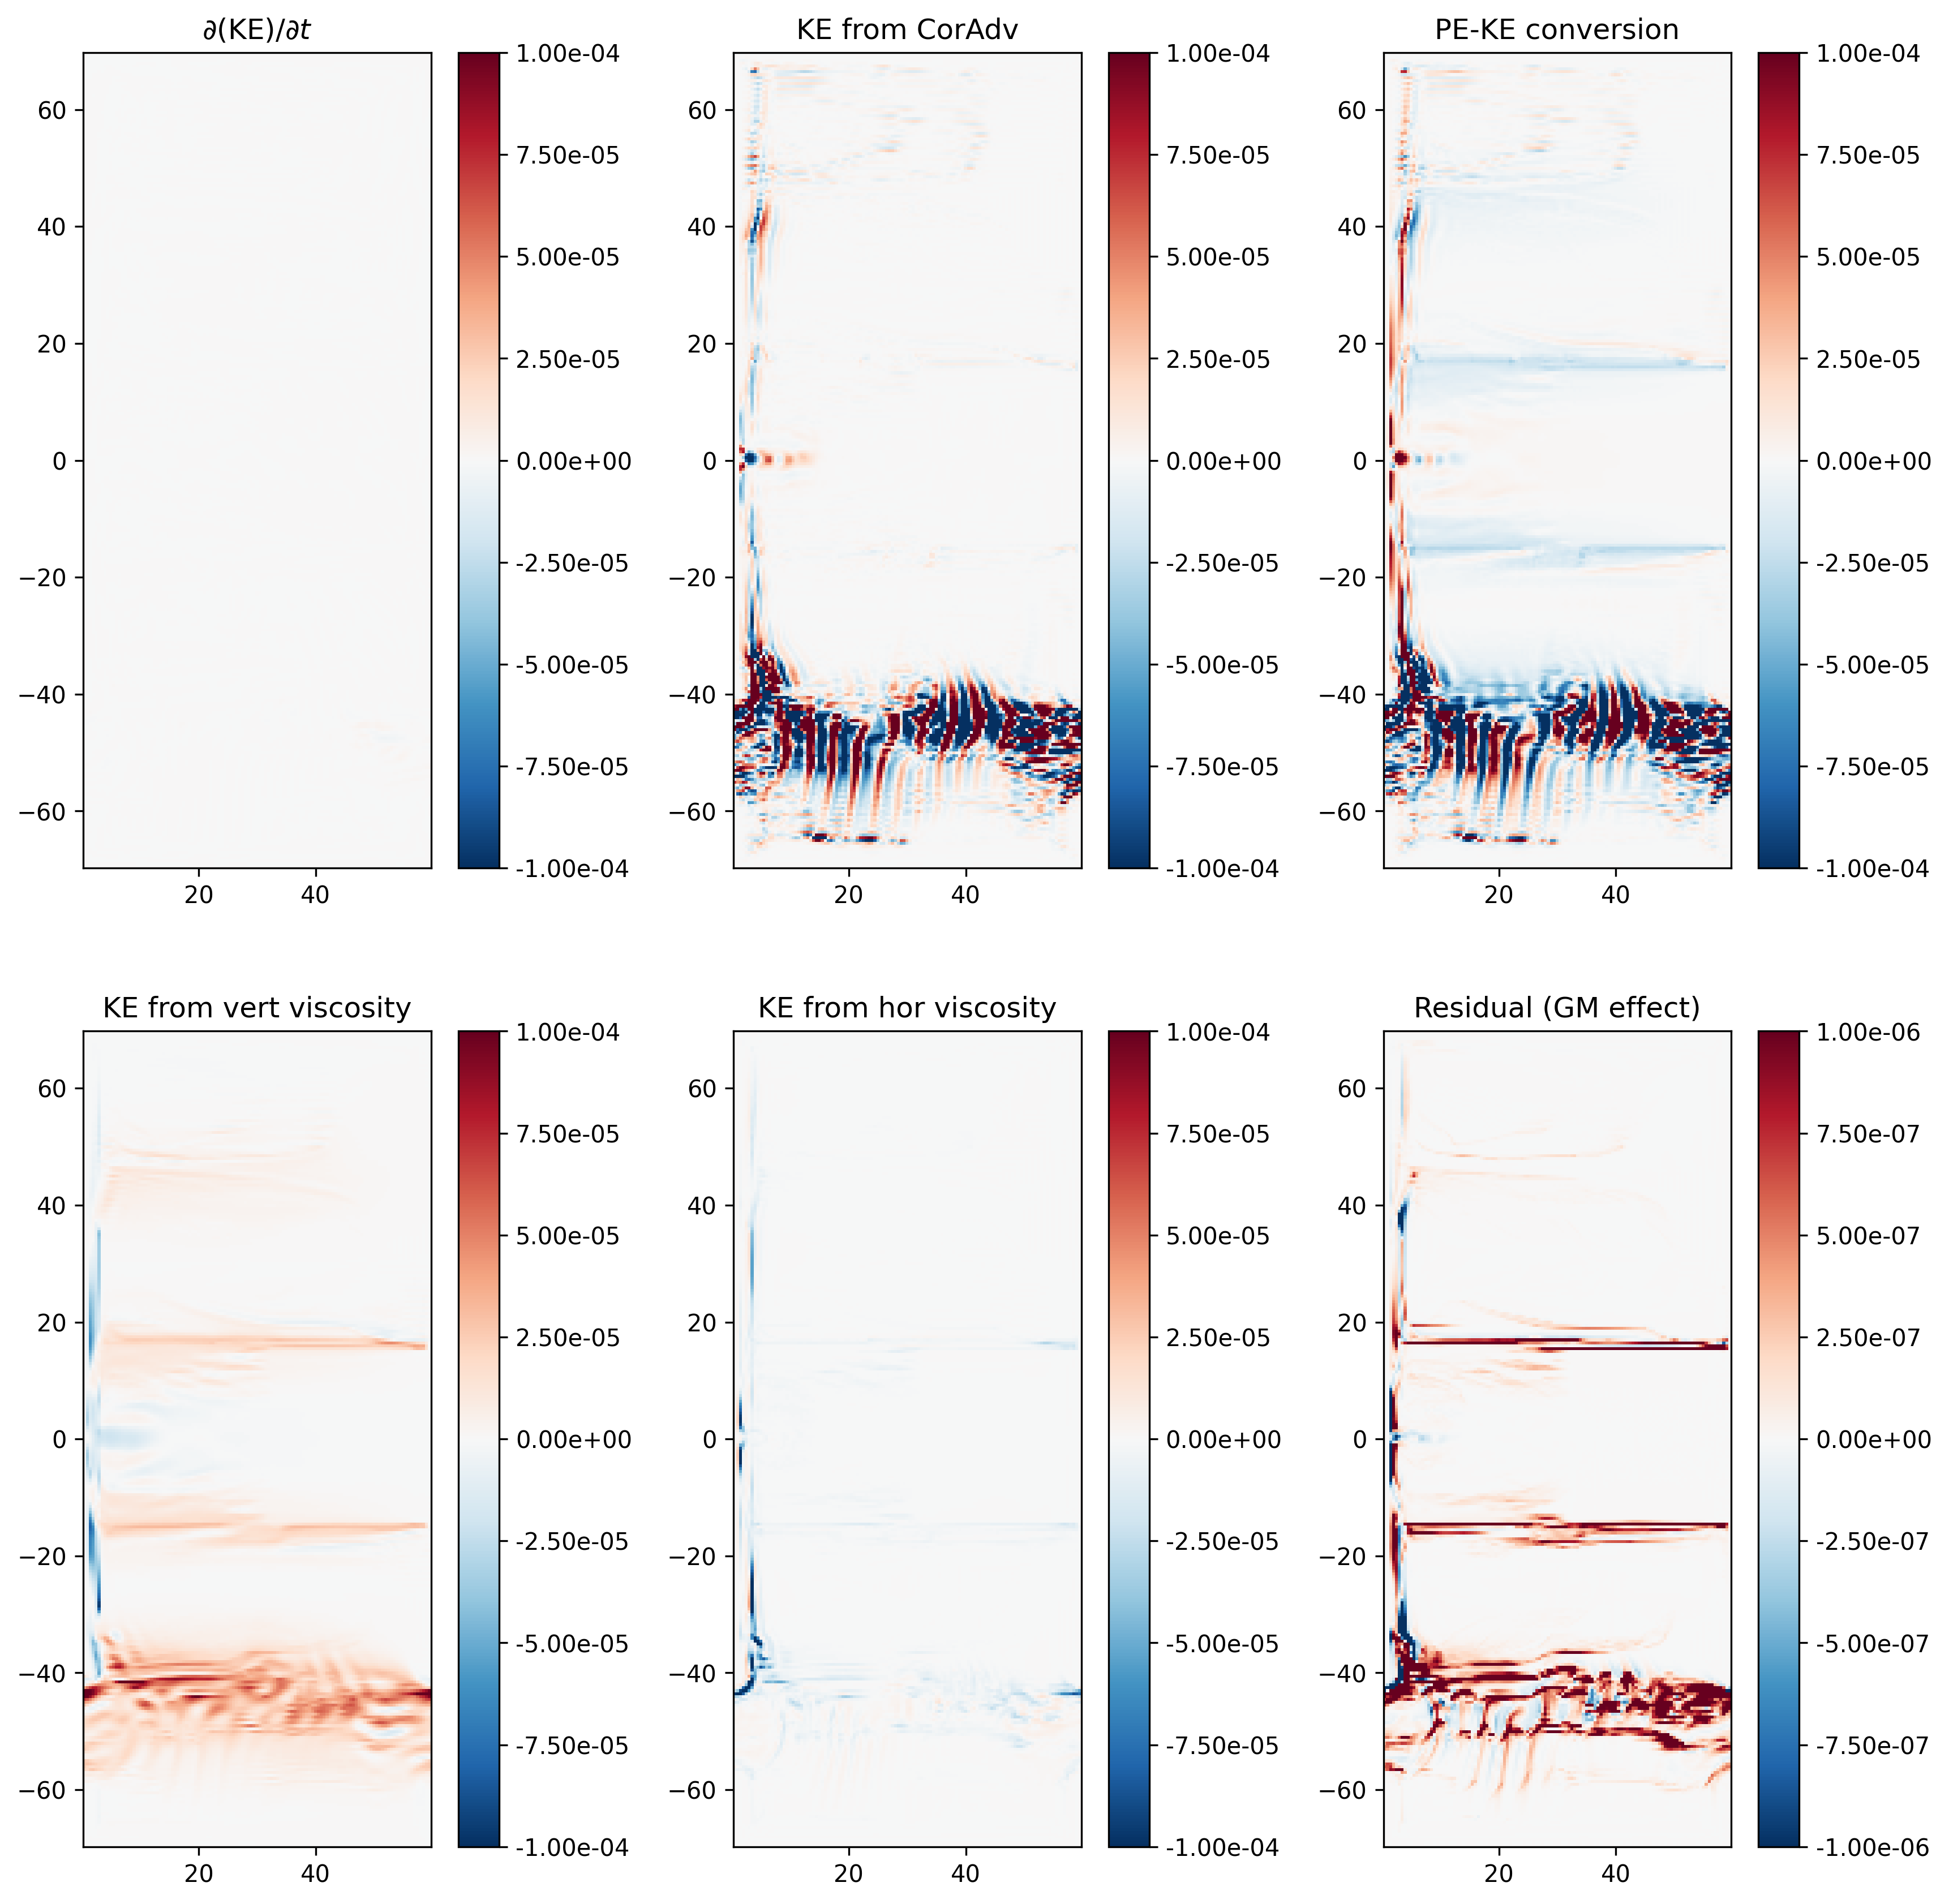

In [23]:
plt.figure(figsize=(14,14),dpi=300)


cmin=-1e-4; cmax=1e-4;
plt.subplot(2,3,1)
plt.pcolormesh(xh,yh,KEterm1,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial ($KE$)/\partial t$')
cbar=plt.colorbar(format='%.2e')

plt.subplot(2,3,2)
plt.pcolormesh(xh,yh,KEterm2,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from CorAdv')
cbar=plt.colorbar(format='%.2e')
plt.subplot(2,3,3)
plt.pcolormesh(xh,yh,(KEterm3+KEterm4),norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'PE-KE conversion')
cbar=plt.colorbar(format='%.2e')


plt.subplot(2,3,4)
plt.pcolormesh(xh,yh,KEterm5,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from vert viscosity')
cbar=plt.colorbar(format='%.2e')

plt.subplot(2,3,5)
plt.pcolormesh(xh,yh,KEterm6,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from hor viscosity')
cbar=plt.colorbar(format='%.2e')

plt.subplot(2,3,6)
plt.pcolormesh(xh,yh,E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin/100,vmax=cmax/100)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'Residual (GM effect)')
cbar=plt.colorbar(format='%.2e')


In [24]:
PEconversion    =KEterm3+KEterm4
PEconversion_int=np.nansum(area_t*PEconversion)/np.nansum(area_t)

PEconversion_int



-3.4152949768433413e-06

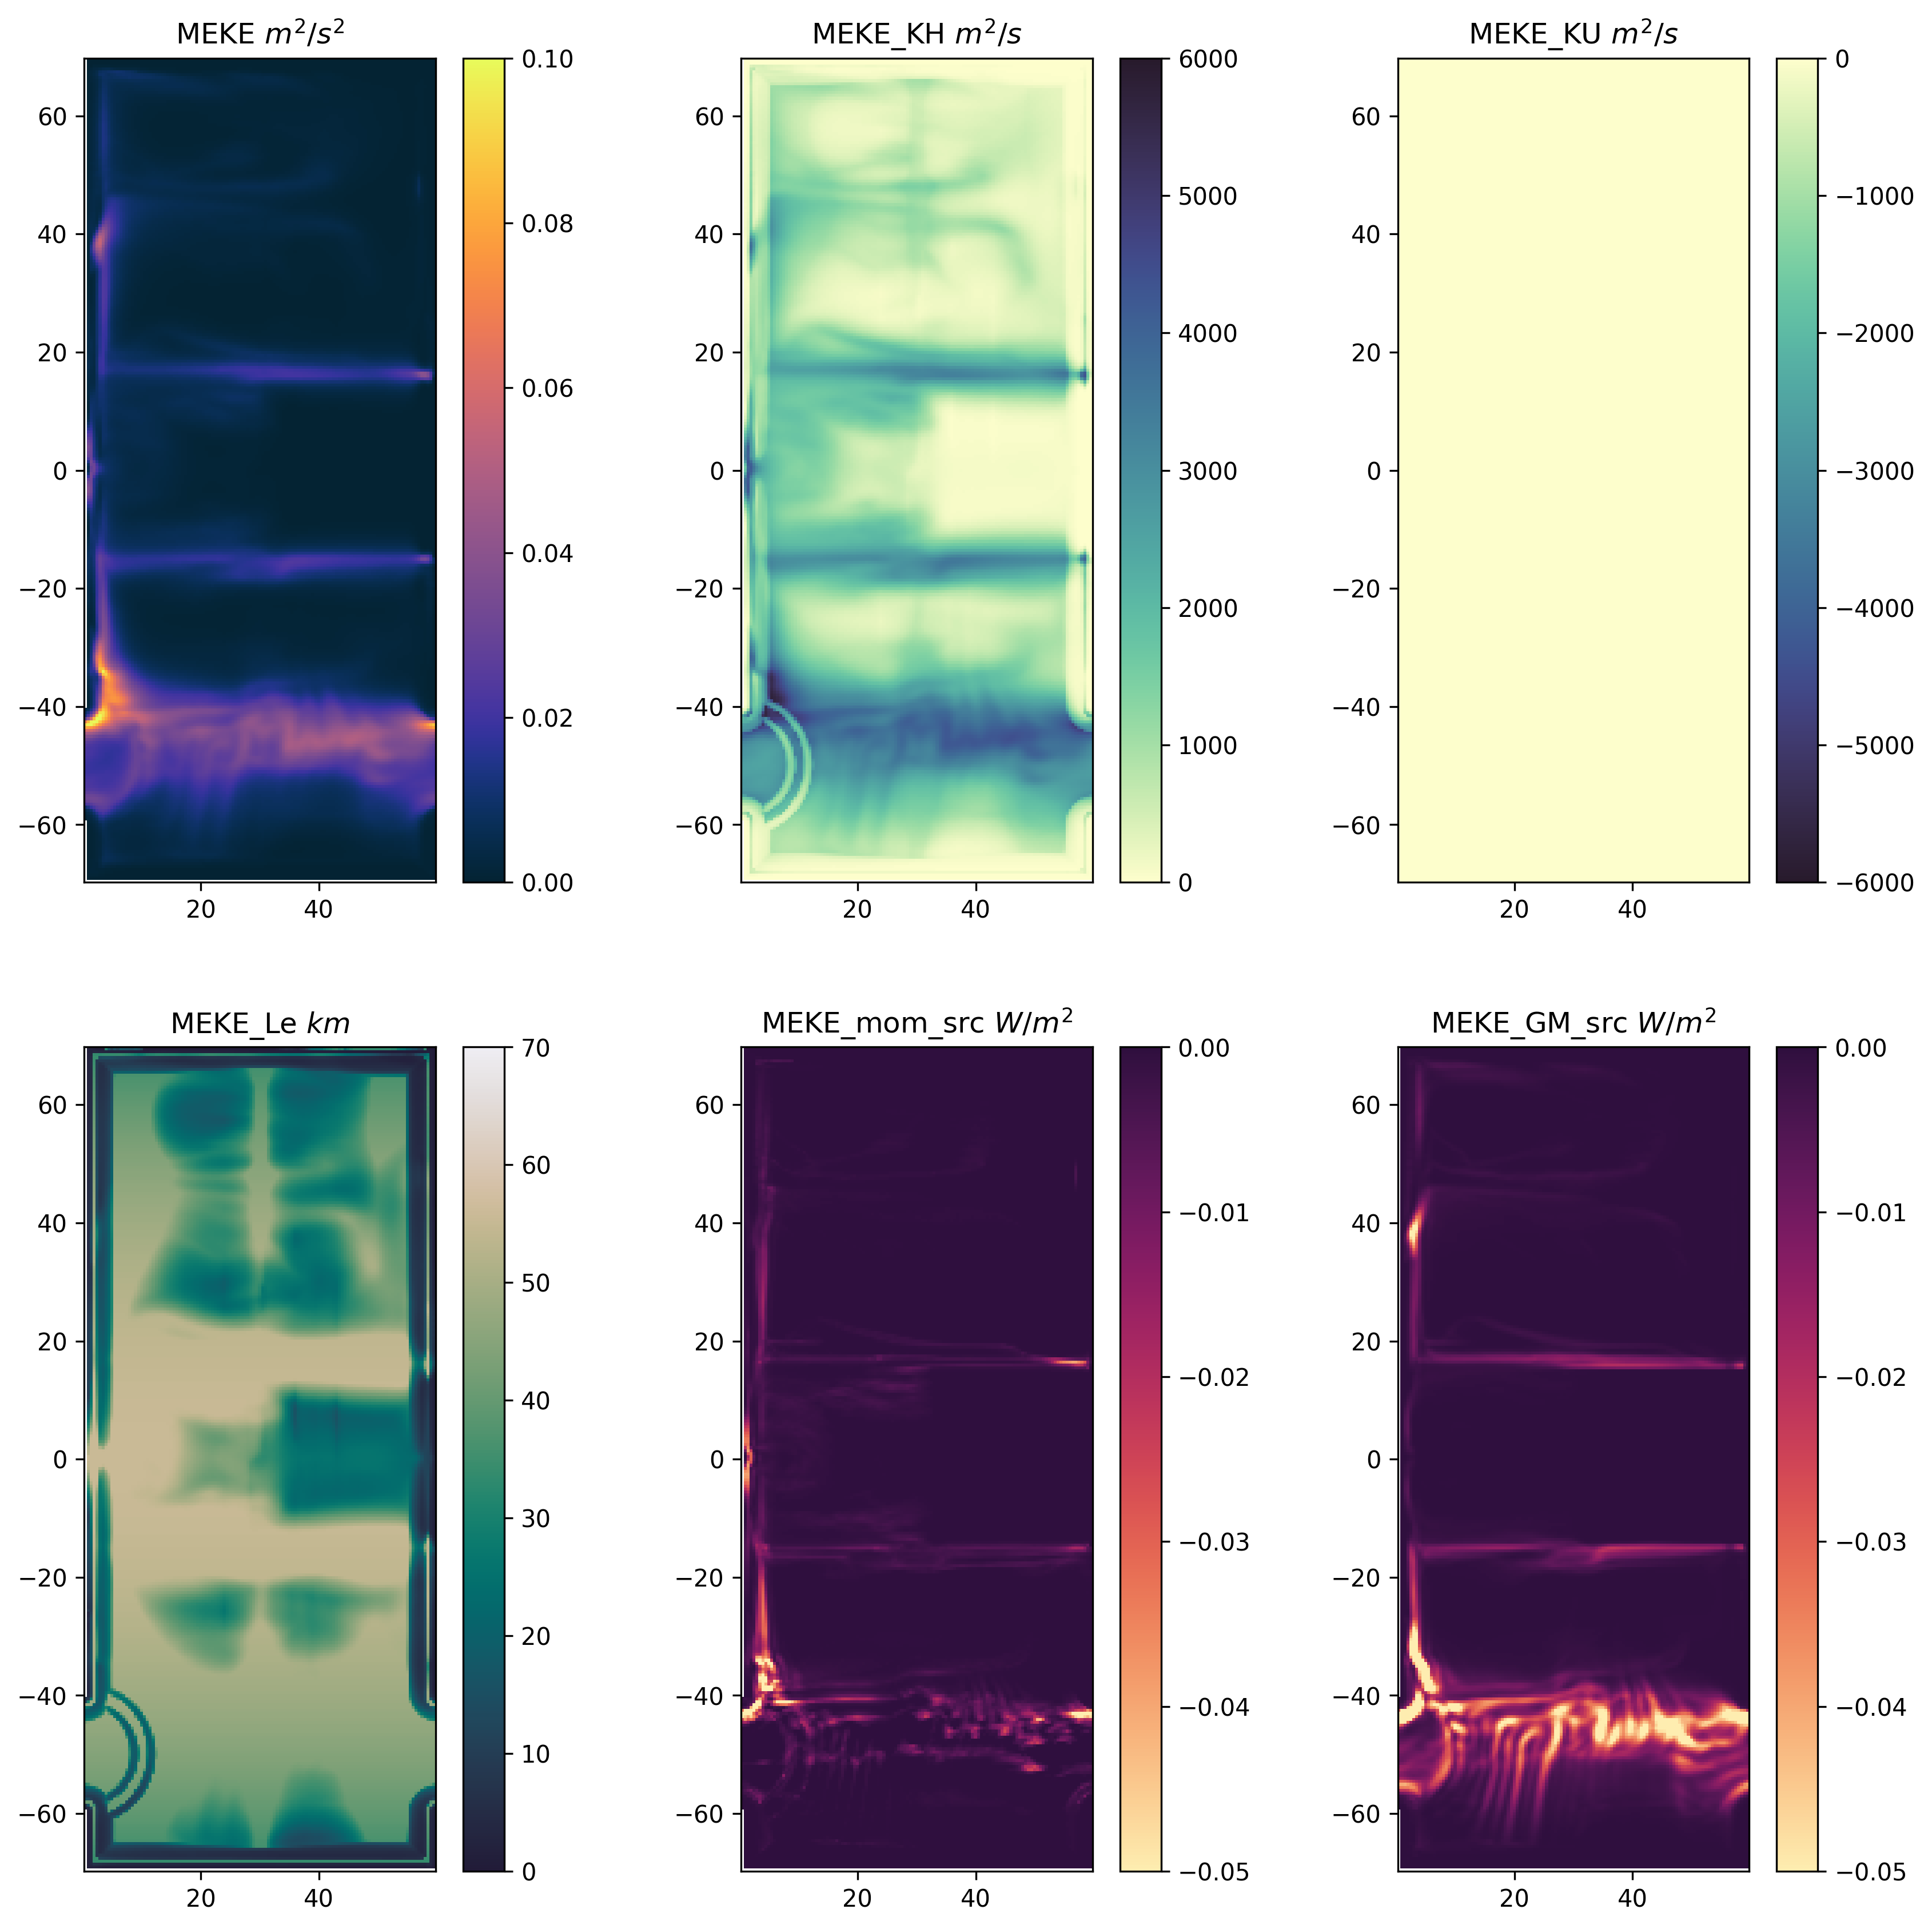

In [26]:
plt.figure(figsize=(14,14),dpi=300)


cmin=-1e-4; cmax=1e-4;
plt.subplot(2,3,1)
plt.pcolormesh(xh,yh,MEKE,cmap=cmocean.cm.thermal,vmin=0.,vmax=.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'MEKE $m^2/s^2$')
plt.colorbar()

plt.subplot(2,3,2)
plt.pcolormesh(xh,yh,MEKE_KH,cmap=cmocean.cm.deep,vmin=0.,vmax=6000)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'MEKE_KH $m^2/s$')
plt.colorbar()

plt.subplot(2,3,3)
plt.pcolormesh(xh,yh,MEKE_KU,cmap=cmocean.cm.deep_r,vmin=-6000.,vmax=0)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'MEKE_KU $m^2/s$')
plt.colorbar()


plt.subplot(2,3,4)
plt.pcolormesh(xh,yh,MEKE_Le/1000,cmap=cmocean.cm.rain_r,vmin=0,vmax=70)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'MEKE_Le $km$')
plt.colorbar()

plt.subplot(2,3,5)
plt.pcolormesh(xh,yh,MEKE_mom_src,cmap=cmocean.cm.matter,vmin=-.05,vmax=0)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'MEKE_mom_src $W/m^2$')
plt.colorbar()

plt.subplot(2,3,6)
plt.pcolormesh(xh,yh,MEKE_GM_src,cmap=cmocean.cm.matter,vmin=-0.05,vmax=0)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'MEKE_GM_src $W/m^2$')

plt.colorbar()

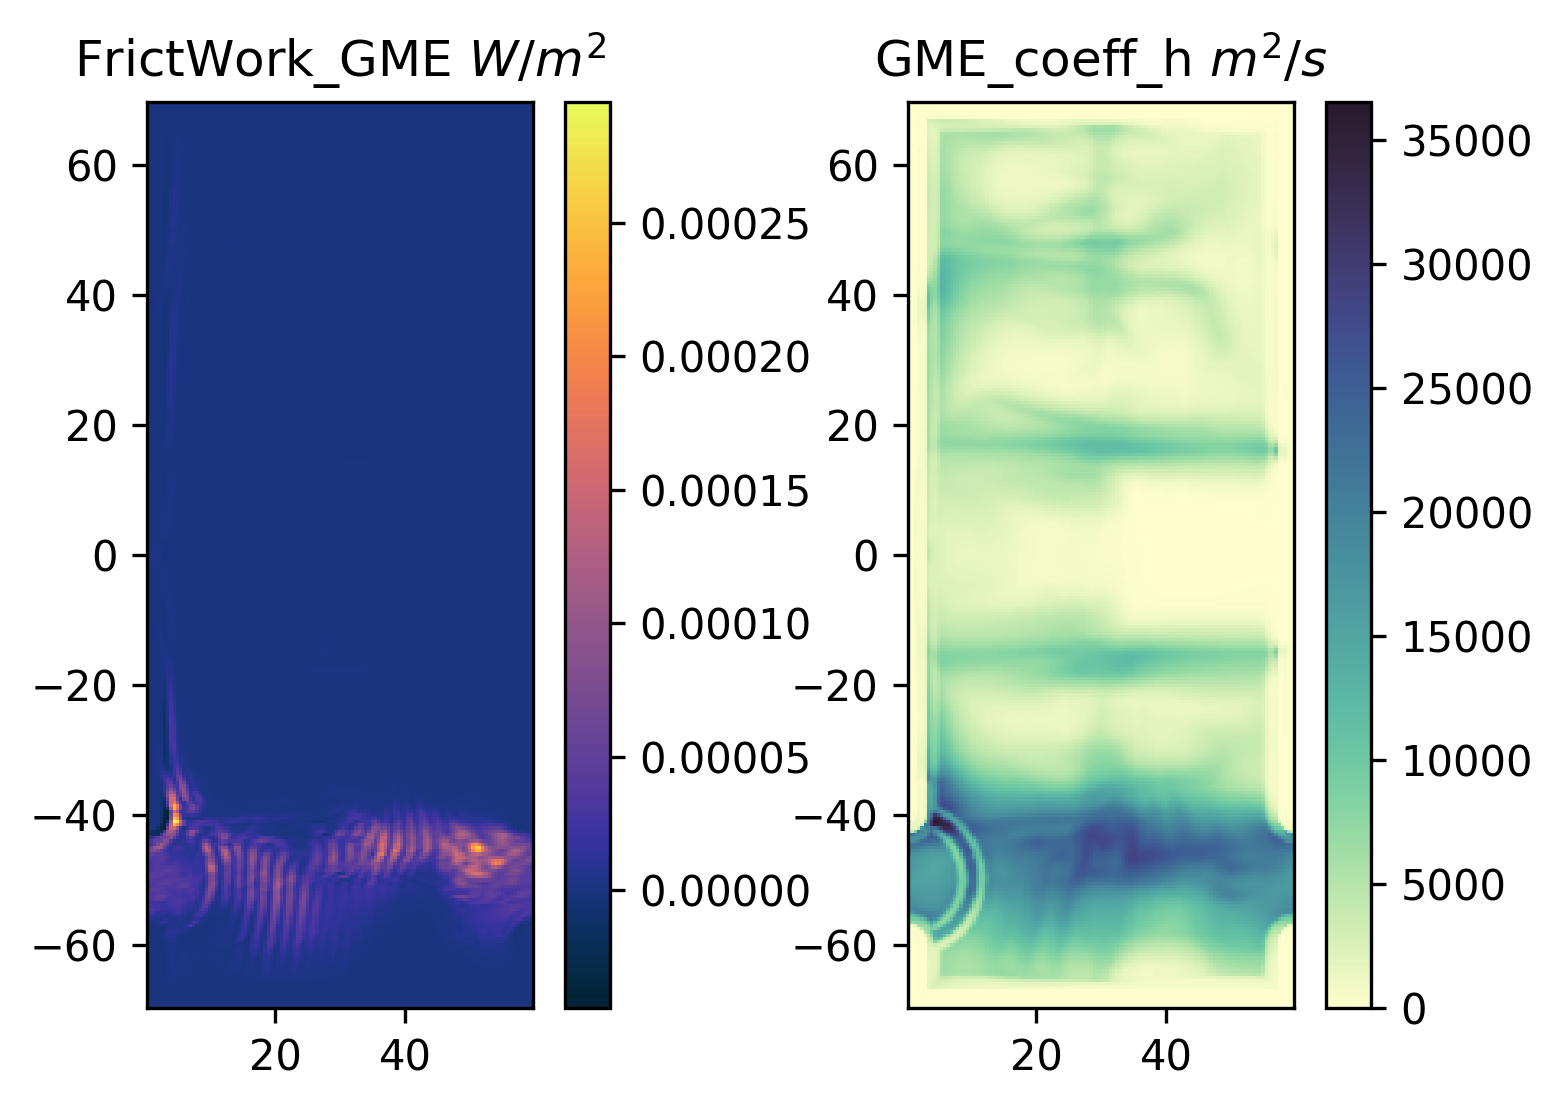

In [33]:
plt.figure(figsize=(6,4),dpi=300)

FrictWork_GME = MEKEav['FrictWork_GME'][:,:,:].mean('time').sum('zl')
GME_coeff_h   = MEKEav['GME_coeff_h'][:,:,:].mean('time').sum('zl')

GME_coeff_h.shape
cmin=-1e-4; cmax=1e-4;
plt.subplot(1,2,1)
plt.pcolormesh(xh,yh,FrictWork_GME,cmap=cmocean.cm.thermal)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'FrictWork_GME $W/m^2$')
plt.colorbar(format='.2e')

plt.subplot(1,2,2)
plt.pcolormesh(xh,yh,GME_coeff_h,cmap=cmocean.cm.deep)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'GME_coeff_h $m^2/s$')
plt.colorbar()
